# Strain mapping with all calibrations
___

## 2B: Calibration - Scan and elliptical distortion measurement

Measure and correct and overall shifts of the diffraction patterns from the scanning of the beam.  Measure the elliptical distortion from the calibration data.  The elliptical distortion parameters are saved for later application to the 4D-STEM data scan.  The elliptical distortions are then corrected in this dataset.

___

- Inputs:
  - Bragg peaks, uncorrected, for the calibration sample
  - Bragg vector map, uncorrected, for the calibration sample
- Outputs:
  - Bragg peaks, corrected, for the calibration sample
  - Bragg vector map, corrected, for the calibration sample
  - elliptical distortion parameters

### Import packages, load data

In [2]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Ellipse
from time import time
from scipy.ndimage.filters import gaussian_filter

# i/o
from py4DSTEM.file.datastructure import DiffractionSlice, RealSlice
from py4DSTEM.file.io import FileBrowser, read, append

# Diffraction shift correction
from py4DSTEM.process.utils import get_CoM
from py4DSTEM.process.calibration import get_diffraction_shifts, find_outlier_shifts, shift_braggpeaks
from py4DSTEM.process.fit import fit_2D
from py4DSTEM.process.braggdiskdetection import get_bragg_vector_map

# Elliptical distortion correction
from py4DSTEM.process.utils import radial_integral, get_maxima_1D
from py4DSTEM.process.calibration import measure_elliptical_distortion, correct_elliptical_distortion

In [11]:
# Examine contents of processing_sampledata.h5

fp_processing = "/media/AuxDriveB/Data/20190904_StrainMappingExample_with_Calibrations/processing_sampledata.h5"
browser = py4DSTEM.file.io.FileBrowser(fp_processing)
browser.show_dataobjects()

 Index                  Name                        Type        
   0    braggvectormap_uncorrected_calibrationdataDiffractionSlice    
   1    probe                               DiffractionSlice    
   2    virtual_image                       RealSlice           
   3    braggpeaks_uncorrected_calibrationdataPointListArray      


In [12]:
# Load data

braggpeaks_uncorrected = browser.get_dataobject('braggpeaks_uncorrected_calibrationdata')
braggvectormap_uncorrected = browser.get_dataobject('braggvectormap_uncorrected_calibrationdata').data
browser.close()

R_Nx,R_Ny = braggpeaks_uncorrected.shape
Q_Nx,Q_Ny = braggvectormap_uncorrected.shape

### Diffraction shifts

Here we measure and correct shifts of the diffraction patterns due to the scanning of the beam in real space.  We proceed as follows:

Measure diffraction shifts
- Get an initial guess at the diffraction shifts
- Find outliers in initial diffraction shift guesses
- Ignoring outliers, fit a plane or parabola to the initial guess.

Correct diffraction shifts
- Apply shifts to the Bragg peak positions

#### Measure diffraction shifts

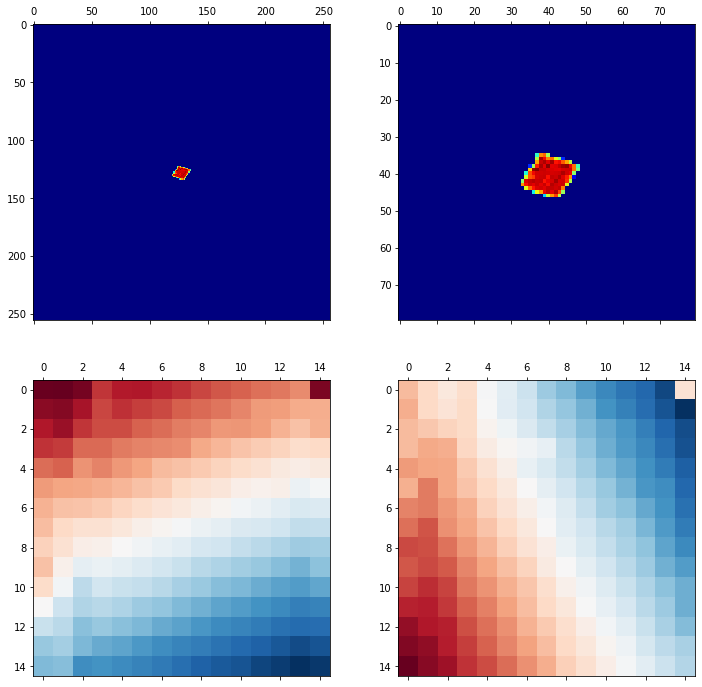

In [14]:
# Get diffraction shifts

findcenter = 'CoM'   # Must be 'CoM' or 'max'
rad = 40             # for display
power = 0.25

xshifts, yshifts, braggvectormap_center = get_diffraction_shifts(braggpeaks_uncorrected,
                                                                 Q_Nx, Q_Ny,
                                                                 findcenter=findcenter)

# Show
x0,y0 = py4DSTEM.process.utils.get_CoM(braggvectormap_center)

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))
ax11.matshow(braggvectormap_center**0.25,cmap='jet')
ax12.matshow(braggvectormap_center[int(x0-rad):int(x0+rad),int(y0-rad):int(y0+rad)]**power,cmap='jet')
ax21.matshow(xshifts,cmap="RdBu")
ax22.matshow(yshifts,cmap="RdBu")
plt.show()

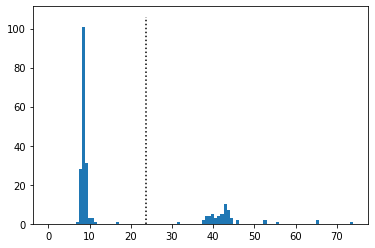

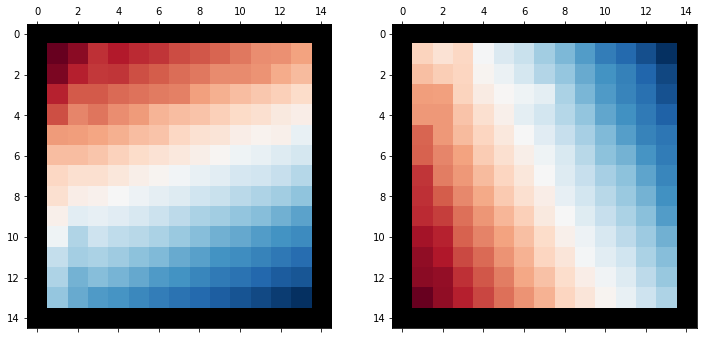

In [17]:
# Find outliers

n_sigma = 50
edge_boundary = 1
n_bins = 100

mask,n,bins,cutoff = find_outlier_shifts(xshifts,yshifts,n_sigma=n_sigma,edge_boundary=edge_boundary,n_bins=n_bins)

# Show
xshifts_masked = np.ma.masked_array(xshifts, mask)
yshifts_masked = np.ma.masked_array(yshifts, mask)
mask_display = np.ma.masked_array(mask, mask==False)

fig,ax = plt.subplots()
ax.bar(bins[:-1]+(bins[1]-bins[0])/2., n, (bins[1]-bins[0]), align='center')
ax.vlines(cutoff,0,ax.get_ylim()[1],linestyle=':')
plt.show()

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(xshifts_masked,cmap="RdBu")
ax2.matshow(yshifts_masked,cmap="RdBu")
ax1.matshow(mask_display)
ax2.matshow(mask_display)
plt.show()

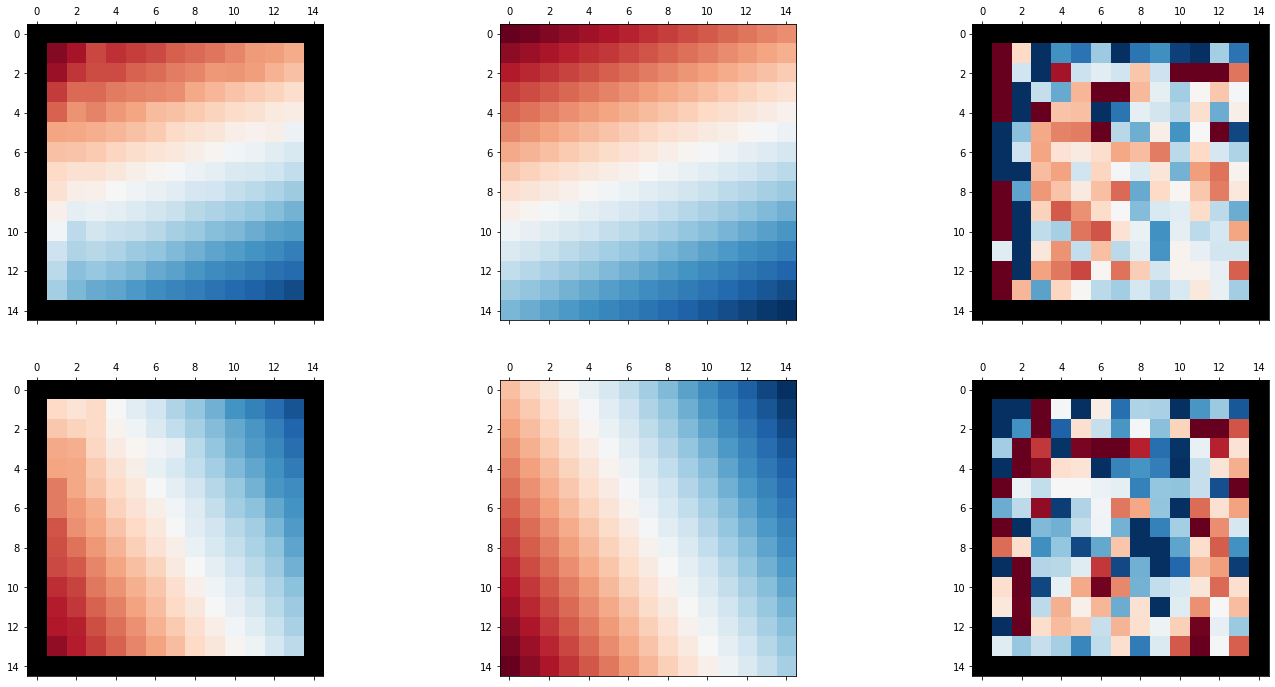

In [18]:
# Fit the diffraction shifts

#fit_function = py4DSTEM.process.fit.plane        # Select fit type
fit_function = py4DSTEM.process.fit.parabola

# Fit
xshifts_fit = np.zeros_like(xshifts)
yshifts_fit = np.zeros_like(yshifts)
popt_x, pcov_x, xshifts_fit = fit_2D(fit_function, xshifts, data_mask=mask==False)
popt_y, pcov_y, yshifts_fit = fit_2D(fit_function, yshifts, data_mask=mask==False)
residuals_x = xshifts-xshifts_fit
residuals_y = yshifts-yshifts_fit
residuals_x[mask] = 0
residuals_y[mask] = 0

# Show
fig,((ax11,ax12,ax13),(ax21,ax22,ax23))=plt.subplots(2,3,figsize=(24,12))
ax11.matshow(xshifts,cmap="RdBu")
ax21.matshow(yshifts,cmap="RdBu")
ax12.matshow(xshifts_fit,cmap="RdBu")
ax22.matshow(yshifts_fit,cmap="RdBu")
ax13.matshow(residuals_x,cmap="RdBu",vmin=np.median(residuals_x)-np.std(residuals_x),vmax=np.median(residuals_x)+np.std(residuals_x))
ax23.matshow(residuals_y,cmap="RdBu",vmin=np.median(residuals_y)-np.std(residuals_y),vmax=np.median(residuals_y)+np.std(residuals_y))
ax11.matshow(mask_display)
ax21.matshow(mask_display)
ax13.matshow(mask_display)
ax23.matshow(mask_display)
plt.show()

#### Correct diffraction shifts

In [19]:
# Apply shifts

braggpeaks_shiftcorrected = shift_braggpeaks(braggpeaks_uncorrected, xshifts_fit, yshifts_fit)

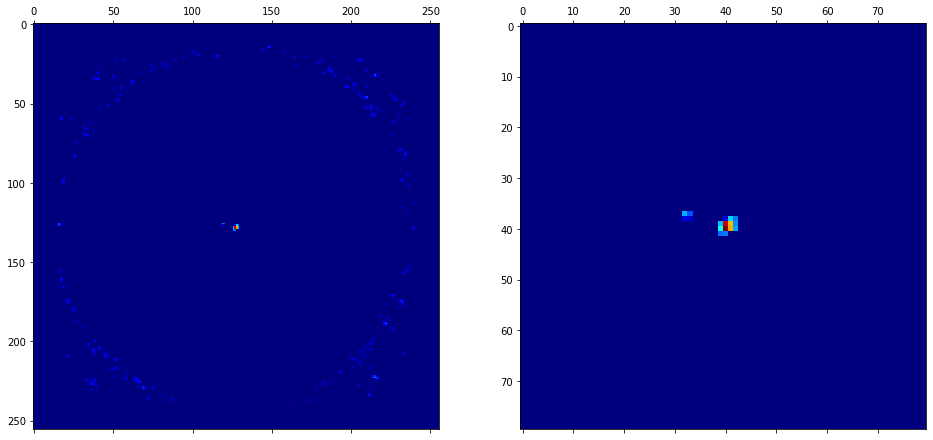

In [20]:
# Re-calculate Bragg vector map and show

braggvectormap_shiftcorrected = get_bragg_vector_map(braggpeaks_shiftcorrected,Q_Nx,Q_Ny)
power = 0.25

# Show
x0,y0=np.unravel_index(np.argmax(gaussian_filter(braggvectormap_shiftcorrected,2)),(Q_Nx,Q_Ny))
x0,y0=int(x0),int(y0)
rad=40

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,8))
ax1.matshow(braggvectormap_shiftcorrected**0.25,cmap='jet')
ax2.matshow(braggvectormap_shiftcorrected[x0-rad:x0+rad,y0-rad:y0+rad]**power,cmap='jet')
plt.show()

### Save

In [21]:
# Store relevant data in  DataObjects

# Diffraction shifts
data = np.zeros((R_Nx,R_Ny,2))
data[:,:,0] = xshifts_fit
data[:,:,1] = yshifts_fit
diffractionshifts = RealSlice(data, slicelabels=('x_shifts','y_shifts'), name='diffractionshifts_calibrationdata')

# Corrected Bragg vector map
braggvectormap_diffslice = DiffractionSlice(braggvectormap_shiftcorrected, name='braggvectormap_calibrationdata_shiftcorrected')

In [25]:
# Append to processing file

dataobjects = [diffractionshifts, braggvectormap_diffslice]

append(dataobjects, fp_processing)

Opening file /media/AuxDriveB/Data/20190904_StrainMappingExample_with_Calibrations/processing_sampledata.h5...
Done.


### 2. Elliptical distortion

Here we measure and correct elliptical distortion of the diffraction patterns due to imperfect electron optics.  We proceed as follows:

- Fit an initial ellipse to an annular region of the Bragg vector map
- Constrain the resulting degenerate ellipse using a known angle between the fitting Bragg peaks
- Correct the elliptical distortions
- Measure final, corrected elliptical distortions

More details are found in notebooks/module_demos/calibration/ellipticaldistortion.ipynb and notebooks/module_demos/calibration/ellipticaldistortion_crystalline.ipynb.

#### Fit initial ellipse

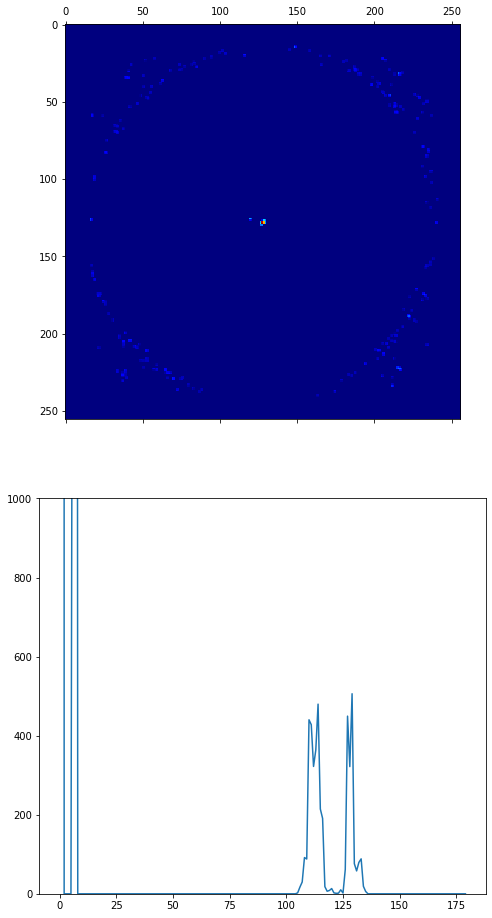

In [29]:
# Show Bragg vector map, calculate radial integral

ymax=1000
power=0.25

x0,y0 = np.unravel_index(np.argmax(gaussian_filter(braggvectormap_shiftcorrected,2)),(Q_Nx,Q_Ny))
radial_profile = radial_integral(braggvectormap_shiftcorrected,x0,y0)[0]

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,16))
ax1.matshow(braggvectormap_shiftcorrected**power,cmap='jet')
ax2.plot(np.arange(len(radial_profile)),radial_profile)
ax2.set_ylim(0,ymax)
plt.show()

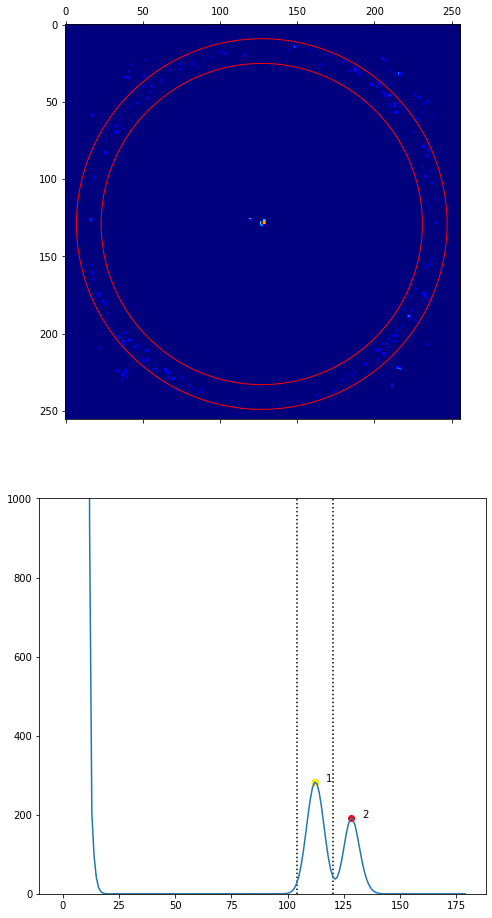

In [32]:
# Specify annular fitting region
# Get annulus center from selected radial profile maximum, specify annulus width

##### Parameters #####
# Find maxima
sigma = 3
minSpacing = 10
minRelativeIntensity = 0.01
relativeToPeak = 1

# Select a maximum and annulus width
selected_index = 1
annulus_width = 16

# Display params
text_offset = 5
power = 0.25
#######################

maxima = get_maxima_1D(radial_profile, sigma=sigma, minSpacing=minSpacing,
                       minRelativeIntensity=minRelativeIntensity,
                       relativeToPeak=relativeToPeak)

r_peak = maxima[selected_index]
r_inner = r_peak - annulus_width/2.
r_outer = r_peak + annulus_width/2.

# Show
profile_smoothed = gaussian_filter(radial_profile,sigma)
fig,(ax2,ax1) = plt.subplots(2,1,figsize=(8,16))
ax1.plot(np.arange(len(profile_smoothed)),profile_smoothed)
ax1.scatter(maxima,profile_smoothed[maxima],color='r')
for i in range(len(maxima)):
    if profile_smoothed[maxima[i]] < ymax:
        ax1.text(maxima[i]+text_offset,profile_smoothed[maxima[i]],'{}'.format(i))
ax1.scatter(r_peak,profile_smoothed[r_peak],color='yellow')
ax1.vlines((r_inner,r_outer),0,ax1.get_ylim()[1],linestyle=":")
ax1.set_ylim(0,ymax)

ax2.matshow(braggvectormap_shiftcorrected**power,cmap='jet')
circle_inner = Circle((y0,x0),radius=r_inner, fill=False, edgecolor='r', linestyle="-")
circle_outer = Circle((y0,x0),radius=r_outer, fill=False, edgecolor='r', linestyle="-")
ax2.add_patch(circle_inner)
ax2.add_patch(circle_outer)

plt.show()

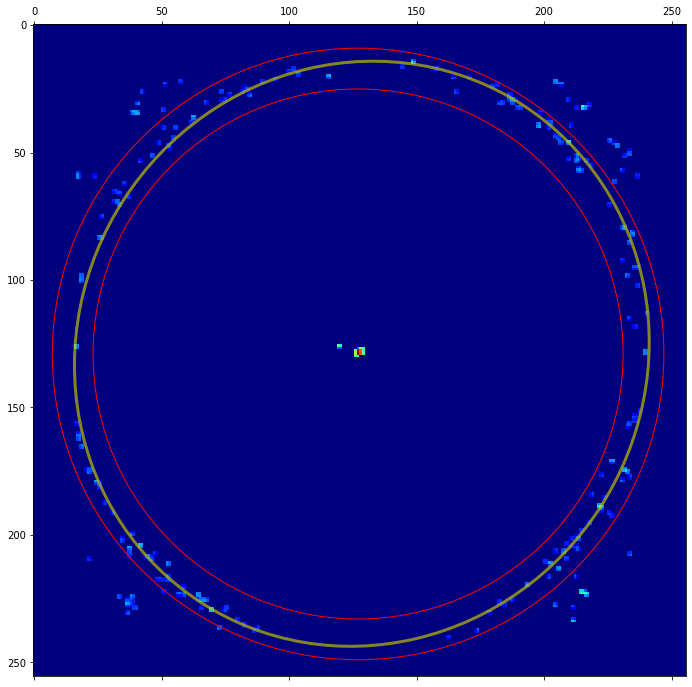

Measured ellipticity = 4.463011560584218%
Measured theta = -32.94128777578223 degrees


In [33]:
# Measure elliptical distortion

power = 0.15

# Measure with no mask
ellipse_params,_ = measure_elliptical_distortion(braggvectormap_shiftcorrected, x0, y0, r_inner, r_outer)
x,y,a,b,theta = ellipse_params

# Show
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(braggvectormap_shiftcorrected**power,cmap='jet')
circle_inner = Circle((y0,x0),radius=r_inner, fill=False,edgecolor='r',linestyle="-")
circle_outer = Circle((y0,x0),radius=r_outer, fill=False,edgecolor='r',linestyle="-")
ellipse = Ellipse((y,x),2*a,2*b,90-np.degrees(theta), fill=False,edgecolor='y',linestyle="-",linewidth=3, alpha=.7)
ax.add_patch(circle_inner)
ax.add_patch(circle_outer)
ax.add_patch(ellipse)
plt.show()

print("Measured ellipticity = {}%".format(100*(max(a,b)/min(a,b)-1)))
print("Measured theta = {} degrees".format(np.degrees(theta)))

#### Correct elliptical distortions

Then, re-measure the elliptical distortions to confirm they've been removed.

In [34]:
# Perform distortion correction

corrected_ellipse_params = [x,y,a,b,theta]
braggpeaks_ellipsecorrected = correct_elliptical_distortion(braggpeaks_shiftcorrected, corrected_ellipse_params)

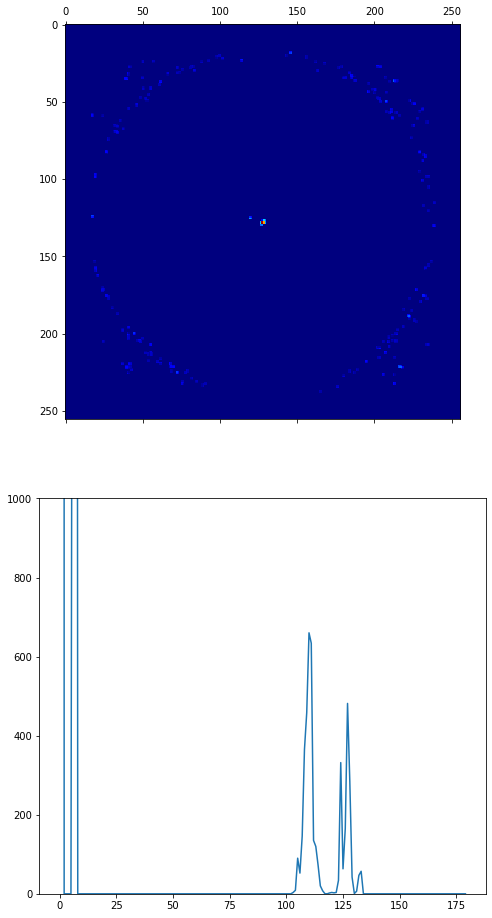

In [35]:
# Get new Bragg vector map and radial integral

power=0.25

braggvectormap_ellipsecorrected = get_bragg_vector_map(braggpeaks_ellipsecorrected,Q_Nx,Q_Ny)
x0,y0 = np.unravel_index(np.argmax(gaussian_filter(braggvectormap_ellipsecorrected,2)),(Q_Nx,Q_Ny))
radial_profile = radial_integral(braggvectormap_ellipsecorrected,x0,y0)[0]

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,16))
ax1.matshow(braggvectormap_ellipsecorrected**power,cmap='jet')
ax2.plot(np.arange(len(radial_profile)),radial_profile)
ax2.set_ylim(0,ymax)
plt.show()

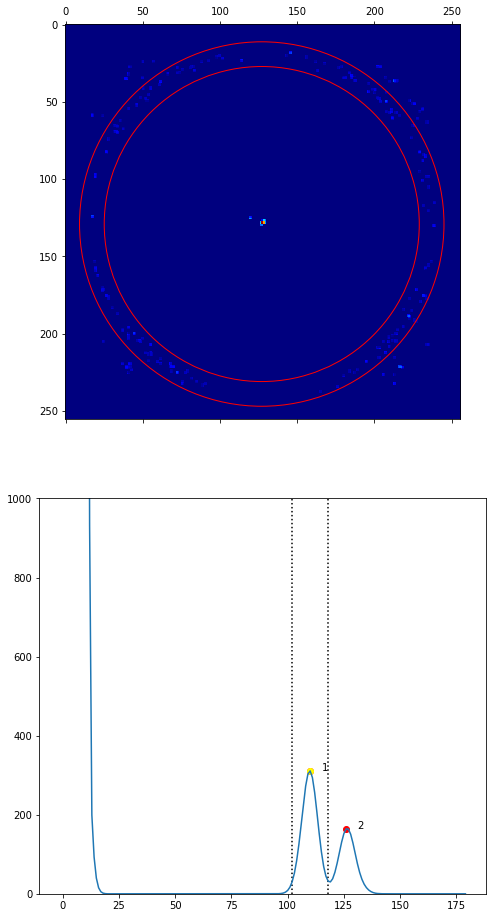

In [37]:
# Get radial profile maxima, and select one

##### Parameters #####
# Find maxima
sigma = 3
minSpacing = 10
minRelativeIntensity = 0.01
relativeToPeak = 1

# Select a maximum
selected_index = 1
annulus_width = 16

# Display params
text_offset = 5
power = 0.25
#######################

maxima = get_maxima_1D(radial_profile, sigma=sigma, minSpacing=minSpacing,
                       minRelativeIntensity=minRelativeIntensity,
                       relativeToPeak=relativeToPeak)

r_peak = maxima[selected_index]
r_inner = r_peak - annulus_width/2.
r_outer = r_peak + annulus_width/2.

# Show
profile_smoothed = gaussian_filter(radial_profile,sigma)
fig,(ax2,ax1) = plt.subplots(2,1,figsize=(8,16))
ax1.plot(np.arange(len(profile_smoothed)),profile_smoothed)
ax1.scatter(maxima,profile_smoothed[maxima],color='r')
for i in range(len(maxima)):
    if profile_smoothed[maxima[i]] < ymax:
        ax1.text(maxima[i]+text_offset,profile_smoothed[maxima[i]],'{}'.format(i))
ax1.scatter(r_peak,profile_smoothed[r_peak],color='yellow')
ax1.vlines((r_inner,r_outer),0,ax1.get_ylim()[1],linestyle=":")
ax1.set_ylim(0,ymax)

ax2.matshow(braggvectormap_ellipsecorrected**power,cmap='jet')
circle_inner = Circle((y0,x0),radius=r_inner, fill=False, edgecolor='r', linestyle="-")
circle_outer = Circle((y0,x0),radius=r_outer, fill=False, edgecolor='r', linestyle="-")
ax2.add_patch(circle_inner)
ax2.add_patch(circle_outer)

plt.show()

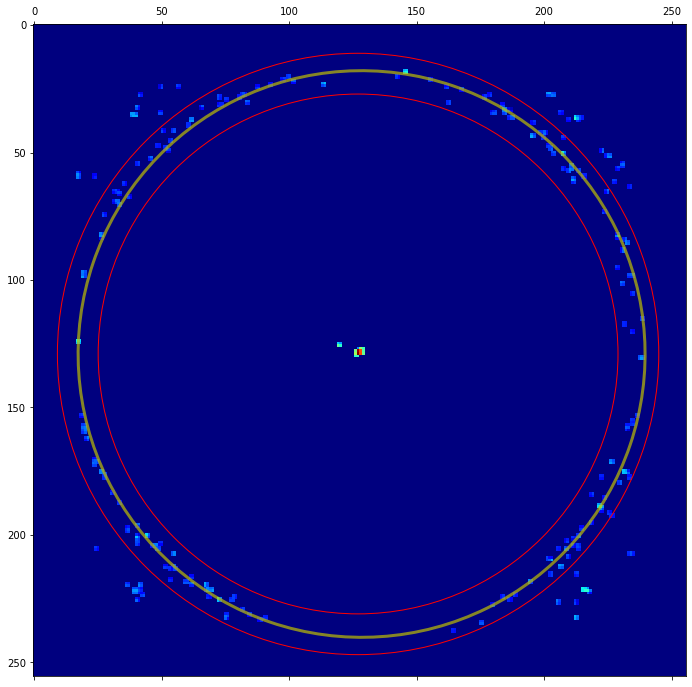

Measured ellipticity = 0.07659535480075697%


In [38]:
# Measure elliptical distortion

power = 0.15

# Measure with no mask
ellipse_params,_ = measure_elliptical_distortion(braggvectormap_ellipsecorrected, x0, y0, r_inner, r_outer)
x_c,y_c,a_c,b_c,theta_c = ellipse_params

# Show
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(braggvectormap_ellipsecorrected**power,cmap='jet')
circle_inner = Circle((y0,x0),radius=r_inner, fill=False,edgecolor='r',linestyle="-")
circle_outer = Circle((y0,x0),radius=r_outer, fill=False,edgecolor='r',linestyle="-")
ellipse = Ellipse((y_c,x_c),2*a_c,2*b_c,90-np.degrees(theta_c), fill=False,edgecolor='y',linestyle="-",linewidth=3, alpha=.7)
ax.add_patch(circle_inner)
ax.add_patch(circle_outer)
ax.add_patch(ellipse)
plt.show()

print("Measured ellipticity = {}%".format(100*(max(a_c,b_c)/min(a_c,b_c)-1)))

### Save

In [43]:
# Store relevant data in  DataObjects

# Ellitpical distortions are saved as a PointList for now.  TODO: save instead in metadata
coords = [('x',float),('y',float),('a',float),('b',float),('theta',float)]
elliptical_distortion_params = py4DSTEM.file.datastructure.PointList(coordinates=coords)
elliptical_distortion_params.name = 'elliptical_distortion'
elliptical_distortion_params.add_point((x,y,a,b,theta))

# Corrected Bragg vector map
braggvectormap_corrected_diffslice = DiffractionSlice(braggvectormap_ellipsecorrected, name='braggvectormap_corrected_calibrationdata')

# Corrected Bragg peaks
braggpeaks_ellipsecorrected.name = 'braggpeaks_corrected_calibrationdata'

In [44]:
# Append to processing file

dataobjects = [braggvectormap_corrected_diffslice, braggpeaks_ellipsecorrected, elliptical_distortion_params]

append(dataobjects, fp_processing)

Opening file /media/AuxDriveB/Data/20190904_StrainMappingExample_with_Calibrations/processing_sampledata.h5...
Done.
